In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import os
import random
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from PIL import Image

In [9]:
#load data
train_dir = 'train'
val_dir = 'val'
test_dir = 'test'



In [13]:
#Check Class Distribution

def count_images(directory):
    for label in ['NORMAL', 'PNEUMONIA']:
        count = len(os.listdir(os.path.join(directory, label)))
        print(f'{label}: {count} images')

print("Training data:")
count_images(train_dir)

print("\nValidation data:")
count_images(val_dir)

print("\nTesting data:")
count_images(test_dir)


Training data:
NORMAL: 1341 images
PNEUMONIA: 3875 images

Validation data:
NORMAL: 8 images
PNEUMONIA: 8 images

Testing data:
NORMAL: 227 images
PNEUMONIA: 390 images


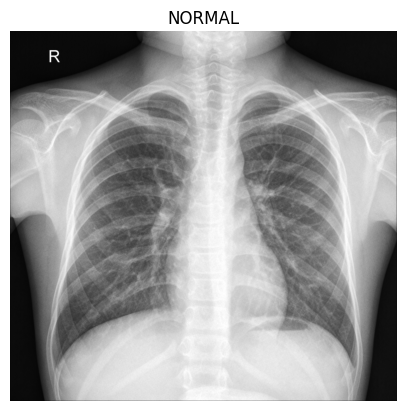

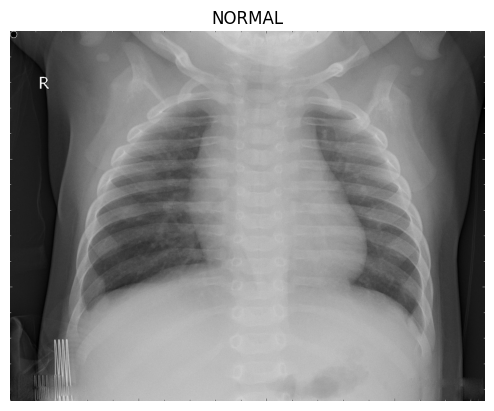

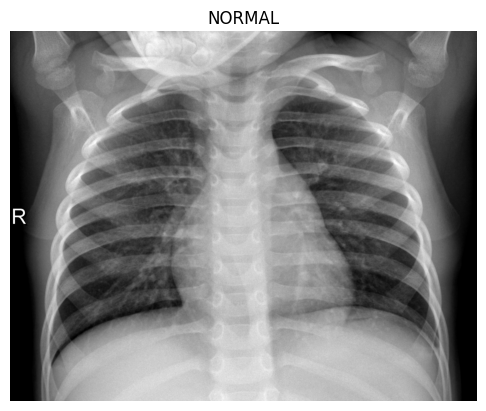

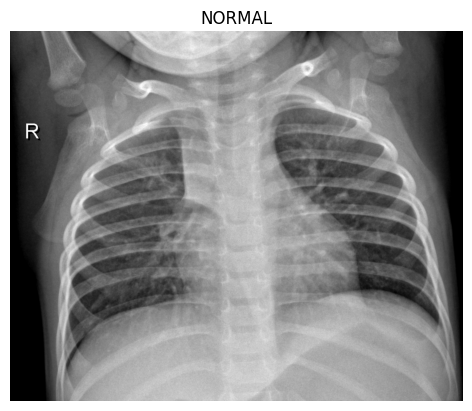

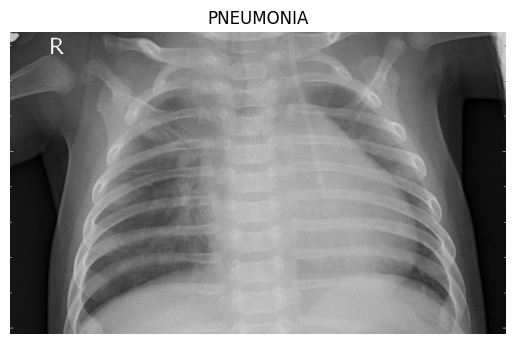

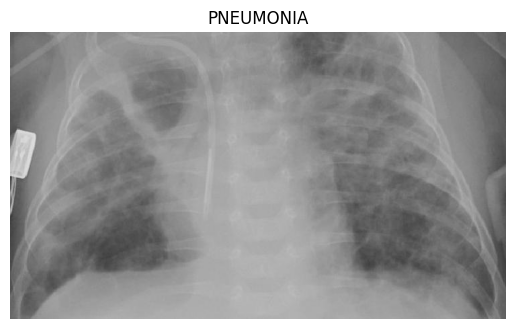

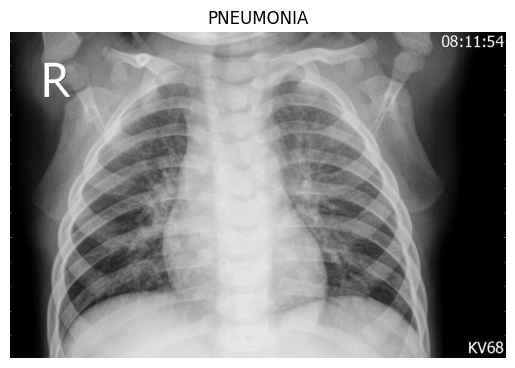

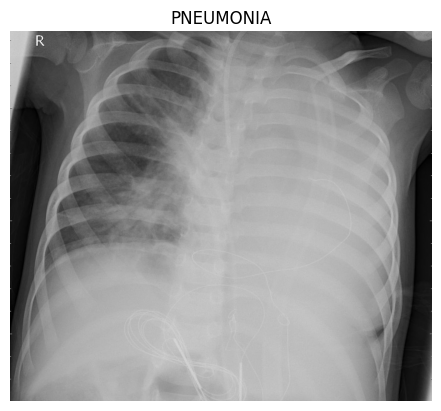

In [19]:
#Visualize Sample Images

def show_random_images(folder, label, n=4):
    files = os.listdir(os.path.join(folder, label))
    samples = random.sample(files, n)
    for img_file in samples:
        img_path = os.path.join(folder, label, img_file)
        img = Image.open(img_path)
        plt.imshow(img, cmap='gray')
        plt.title(label)
        plt.axis('off')
        plt.show()

show_random_images(train_dir, 'NORMAL')
show_random_images(train_dir, 'PNEUMONIA')


In [20]:

#Load Data with ImageDataGenerator
img_size = 150  #set image size
train_datagen = ImageDataGenerator(
    rescale=1./255,              # normalize pixel values (0–1)
    rotation_range=30,           # random rotation (up to 20 degrees)
    zoom_range=0.2,              # random zoom in/out (up to 20%)
    shear_range=0.2,             # slant the image (shearing)
    horizontal_flip=True         # flip images horizontally
)
val_test_datagen = ImageDataGenerator(rescale=1./255)
#load images from folders
train_gen = train_datagen.flow_from_directory(
    train_dir,                            # path to 'train' folder
    target_size=(img_size, img_size),     # resize each image
    batch_size=32,                        # number of images per batch
    class_mode='binary'                   # because we have 2 classes
)
#Validation set 
val_gen = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='binary'
)
#Test set 
test_gen = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='binary',
    shuffle=False        # Important for evaluation — keeps test order fixed
)




Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 617 images belonging to 2 classes.


In [21]:
#CNN

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D(2, 2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


c:\Users\kassi\Desktop\Disease detection\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
#Transfer Learning

# Load base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model_tl = Model(inputs=base_model.input, outputs=predictions)

model_tl.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model_tl.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [24]:
#train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)


c:\Users\kassi\Desktop\Disease detection\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 128s 778ms/step - accuracy: 0.7307 - loss: 0.5748 - val_accuracy: 0.8125 - val_loss: 0.6375
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 98s 600ms/step - accuracy: 0.8759 - loss: 0.3041 - val_accuracy: 0.8750 - val_loss: 0.7665
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 149s 914ms/step - accuracy: 0.8820 - loss: 0.2839 - val_accuracy: 0.7500 - val_loss: 0.8161
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 120s 731ms/step - accuracy: 0.8996 - loss: 0.2442 - val_accuracy: 0.7500 - val_loss: 0.7404
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 162s 994ms/step - accuracy: 0.9144 - loss: 0.2281 - val_accuracy: 0.6250 - val_loss: 1.1052
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 84s 513ms/step - accuracy: 0.9172 - loss: 0.2104 - val_accuracy: 0.6875 - val_loss: 0.8292
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 88s 541ms/step - accuracy: 0.9212 - loss: 0.1960 - val_accuracy: 0.6875 - val_loss: 0.9845
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 97s 594ms/step - accuracy: 0.9320 - los

In [25]:
# Fine-tune — unfreeze part of base model
base_model.trainable = True
for layer in base_model.layers[:-30]:  # Freeze all but last 30 layers
    layer.trainable = False

# Recompile with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Fine-tune training
fine_tune_history = model.fit(train_gen,
                              validation_data=val_gen,
                              epochs=5)  # additional epochs

Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 106s 640ms/step - accuracy: 0.9425 - loss: 0.1507 - val_accuracy: 0.7500 - val_loss: 0.5731
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 500ms/step - accuracy: 0.9448 - loss: 0.1465 - val_accuracy: 0.7500 - val_loss: 0.6104
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 157s 967ms/step - accuracy: 0.9520 - loss: 0.1389 - val_accuracy: 0.6875 - val_loss: 0.6325
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 158s 690ms/step - accuracy: 0.9476 - loss: 0.1423 - val_accuracy: 0.6875 - val_loss: 0.6273
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 0.9505 - loss: 0.1285 - val_accuracy: 0.6875 - val_loss: 0.6120


In [26]:
#Evaluate it on the test set
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.2f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - accuracy: 0.8570 - loss: 0.3746
Test Accuracy: 0.90


In [27]:
# Predict on test set
pred_probs = model.predict(test_gen)
pred_classes = (pred_probs > 0.5).astype("int32")  # Convert probabilities to 0 or 1

# True labels
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())  # ['NORMAL', 'PNEUMONIA']

# Classification report
print(classification_report(true_classes, pred_classes, target_names=class_labels))


20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step
              precision    recall  f1-score   support

      NORMAL       0.96      0.77      0.86       227
   PNEUMONIA       0.88      0.98      0.93       390

    accuracy                           0.90       617
   macro avg       0.92      0.88      0.89       617
weighted avg       0.91      0.90      0.90       617



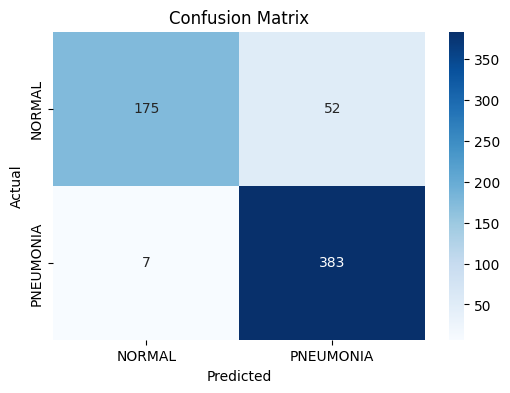

In [30]:
#Confusion Matrix

# Compute confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Plot it
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


1. True Positives (TP) = 383
These are pneumonia cases that were correctly predicted as pneumonia.

2. True Negatives (TN) = 175
These are normal cases correctly predicted as normal.

3. False Positives (FP) = 52
These are normal cases wrongly predicted as pneumonia.

4. False Negatives (FN) = 7
These are pneumonia cases wrongly predicted as normal.


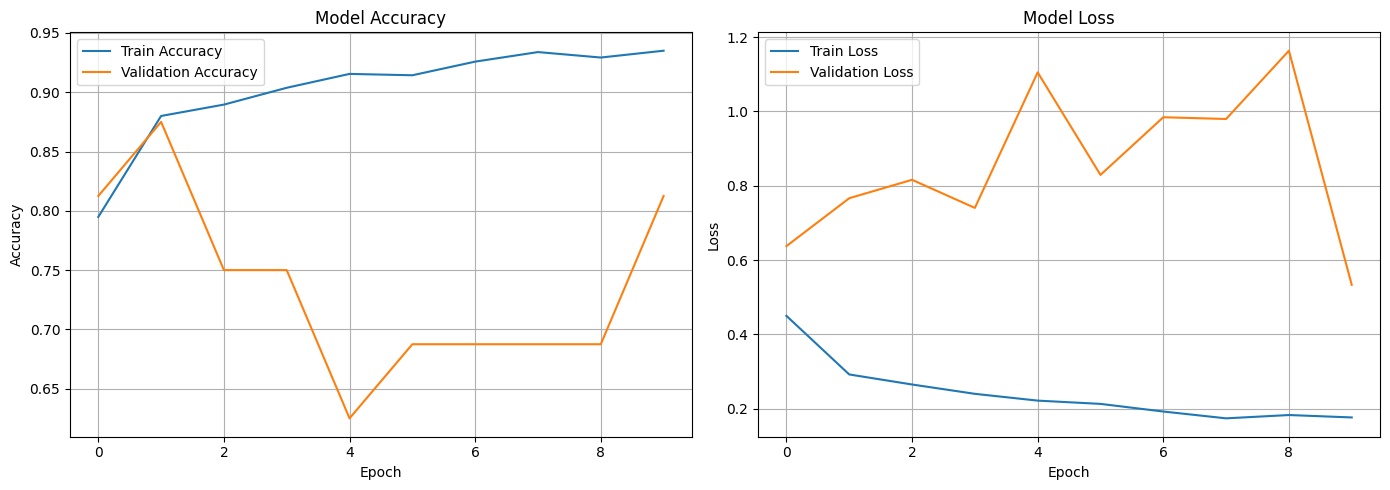

In [31]:

# Accuracy Curves
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Curves
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


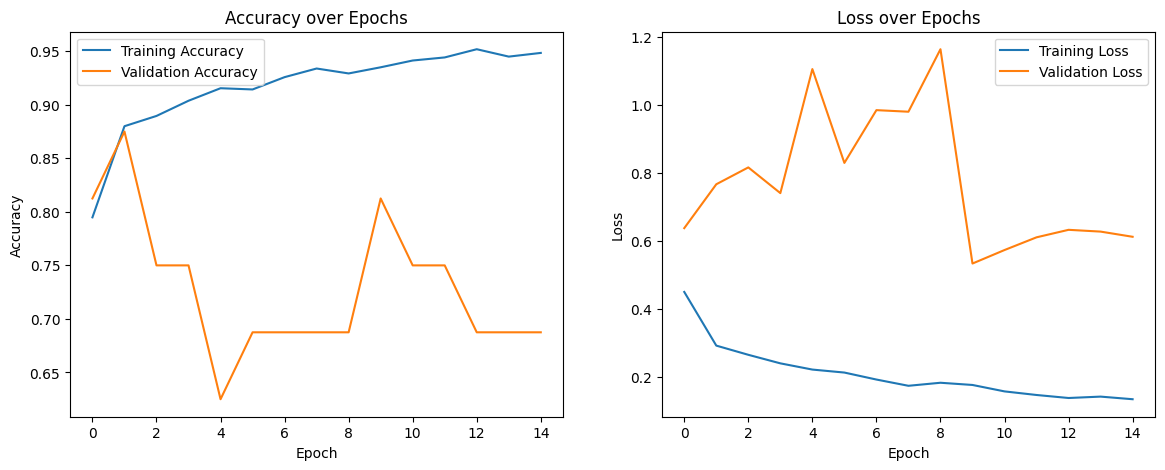

In [32]:
# Combine histories
acc = history.history['accuracy'] + fine_tune_history.history['accuracy']
val_acc = history.history['val_accuracy'] + fine_tune_history.history['val_accuracy']

loss = history.history['loss'] + fine_tune_history.history['loss']
val_loss = history.history['val_loss'] + fine_tune_history.history['val_loss']

# Plot
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


Conclusion:
The model performs very well:

It catches most pneumonia cases (high recall).

It doesn't make many false alarms (high precision).

Overall, the model is safe and reliable for assisting diagnosis.